# Traffic and R_eff

Let's examine whether general traffic can explain changes in the effective reproductive ratio, as estimated by Price 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-poster')
from datetime import datetime as dt
from Reff_functions import *
from Reff_constants import *

Read in all the data

In [13]:
# Reff estimates from Price et al 2020
#df_Reff = read_in_Reff() #estimates up to 14th April

df_Reff = read_in_LSHTM()#read_in_Reff()
df_Reff = df_Reff.loc[df_Reff.date_of_analysis=='2020-07-16']

df_state = read_in_cases(case_file_date=['20Jul','0930'])

df_Reff = df_Reff.merge(df_state,how='left',left_on=['state','date'], right_on=['STATE','date_inferred']) #how = left to use Reff days, NNDSS missing dates
df_Reff['rho_moving'] = df_Reff.groupby(['state'])['rho'].transform(lambda x: x.rolling(7,1).mean()) #minimum number of 1

#some days have no cases, so need to fillna
df_Reff['rho_moving'] = df_Reff.rho_moving.fillna(method='bfill')
df_Reff['local'] = df_Reff.local.fillna(0)
df_Reff['imported'] = df_Reff.imported.fillna(0)
#Add Insight traffic
#df_ai = read_AddInsight()

df_apple = read_in_apple(local=True, moving=True)
df_FB = read_in_FB()
df_google = read_in_google(local=True,moving=True)


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Latest date in Google indices 2020-07-14T00:00:00.000000000


In [15]:
## #Merge all dataframes together

df= df_google.merge(df_Reff[['date','state','mean','lower','upper',
                             'top','bottom','std','rho','rho_moving','local','imported']], on=['date','state'],how='inner')
#df = df.merge(df_apple,on=['date','state'],how='outer') ##Note apple only has WA, VIC,NSW,QLD
#df = df.merge(df_FB,on=['date','state'],how='outer') # inner only gets NSW, VIC, but then lose the other dates

#Forward fill the data from FB
#df['Nij_norm'] = df.groupby('state').Nij_norm.transform(lambda x: x.fillna(method='ffill')) 
#df['pc'] = df.groupby('state').pc.transform(lambda x: x.fillna(method='ffill')) 



In [16]:
surveys = pd.read_csv("../data/md/Barometer wave 1 to 10.csv",parse_dates = ['date'])
surveys = surveys.append(pd.read_csv("../data/md/Barometer wave 11 complience.csv",parse_dates=['date'])) #they spelt compliance wrong??

for i in range(12,17):
    surveys = surveys.append(pd.read_csv("../data/md/Barometer wave "+str(i)+" compliance.csv",parse_dates=['date']))

surveys.loc[surveys.state!='ACT','state'] = surveys.loc[surveys.state!='ACT','state'].map(states_initials).fillna(surveys.loc[surveys.state!='ACT','state'])
surveys['proportion'] = surveys['count']/surveys.respondents
surveys.date = pd.to_datetime(surveys.date)
display(surveys)
always =surveys.loc[surveys.response=='Always'].set_index(["state",'date'])
always = always.unstack(['state'])


idx = pd.date_range('2020-03-01','2020-07-15')

always = always.reindex(idx, fill_value=np.nan)

always.index.name = 'date'

always =always.fillna(method='bfill')
always = always.stack(['state'])

#Zero out before first survey 20th March
always = always.reset_index().set_index('date')
always.loc[:'2020-03-20','count'] =0
always.loc[:'2020-03-20','respondents'] =0
always.loc[:'2020-03-20','proportion'] =0

always = always.reset_index().set_index(['state','date'])

survey_X = pd.pivot_table(data=always,
                          index='date',columns='state',values='proportion')
survey_counts =pd.pivot_table(data=always,
                          index='date',columns='state',values='count').drop(['Australia','Other'],axis=1).astype(int)

survey_respond = pd.pivot_table(data=always,
                          index='date',columns='state',values='respondents').drop(['Australia','Other'],axis=1).astype(int)


display(always.head())
display(always.tail())
survey_X

,date,state,question,response,count,respondents,proportion
0,2020-03-27,ACT,1.5m compliance,Sometimes,2,17,0.117647
1,2020-03-27,ACT,1.5m compliance,Often,5,17,0.294118
2,2020-03-27,ACT,1.5m compliance,Always,10,17,0.588235
3,2020-04-03,ACT,1.5m compliance,Sometimes,1,10,0.100000
4,2020-04-03,ACT,1.5m compliance,Often,1,10,0.100000
...,...,...,...,...,...,...,...
114,2020-07-15,WA,hand hygine,I washed or sanitised my hands as soon as I co...,116,360,0.322222
115,2020-07-15,WA,hand hygine,No,30,360,0.083333
116,2020-07-15,WA,hand hygine,"Yes, I washed or sanitised my hands immediatel...",214,360,0.594444
117,2020-07-15,WA,non-household contact,No,177,360,0.491667


,,question,response,count,respondents,proportion
state,date,,,,,
ACT,2020-03-01,1.5m compliance,Always,0.0,0.0,0.0
Australia,2020-03-01,1.5m compliance,Always,0.0,0.0,0.0
NSW,2020-03-01,1.5m compliance,Always,0.0,0.0,0.0
NT,2020-03-01,1.5m compliance,Always,0.0,0.0,0.0
Other,2020-03-01,1.5m compliance,Always,0.0,0.0,0.0


,,question,response,count,respondents,proportion
state,date,,,,,
QLD,2020-07-15,1.5m compliance,Always,145.0,369.0,0.392954
SA,2020-07-15,1.5m compliance,Always,115.0,318.0,0.361635
TAS,2020-07-15,1.5m compliance,Always,43.0,86.0,0.500000
VIC,2020-07-15,1.5m compliance,Always,192.0,397.0,0.483627
WA,2020-07-15,1.5m compliance,Always,109.0,360.0,0.302778


state,ACT,Australia,NSW,NT,Other,QLD,SA,TAS,VIC,WA
date,,,,,,,,,,
2020-03-01,0.000000,0.0,0.00,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2020-03-02,0.000000,0.0,0.00,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2020-03-03,0.000000,0.0,0.00,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2020-03-04,0.000000,0.0,0.00,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2020-03-05,0.000000,0.0,0.00,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2020-07-11,0.255319,NaN,0.42,0.1875,NaN,0.392954,0.361635,0.5,0.483627,0.302778
2020-07-12,0.255319,NaN,0.42,0.1875,NaN,0.392954,0.361635,0.5,0.483627,0.302778
2020-07-13,0.255319,NaN,0.42,0.1875,NaN,0.392954,0.361635,0.5,0.483627,0.302778


## Gamma model

Let us use a Gamma distribution, so that the mobility indices affect the transmission rate (the location parameter) and the recovery rate (inverse of serial interval) is the shape parameter.


\begin{equation}
\boldsymbol{\beta} \sim Normal ( 0, 1)\\
R_I \sim Gamma(0.25,0.5)\\
R_L \sim Gamma(2.4, 1)\\
\hat{\mu} =  \rho * R_I + \left( 1- \rho \right) 2* R_L * \left(  md^{p} \right) \text{logistic} \left( \boldsymbol{\beta^T} * \boldsymbol{\omega} \right)\\
md^{p} = (1 + \theta_{md}) ^{-\gamma} \\
\hat{\mu} \sim Gamma ( k, \theta)\\
k = \frac{R_{eff}^2}{\sigma^2} \\
\theta = \frac{\sigma^2}{R_{eff}}\\
\end{equation}

Where $\omega$ are the Google social mobility indices. This implies that the mean and variance of the Gamma distribution is:

\begin{equation}
\mu = k \theta = R_{eff}\\
\sigma^2 = k \theta^2 = \sigma^2\\
\end{equation}

We are using R_eff that was derived through the LSHTM method detailed in [this paper](https://academic.oup.com/aje/article/178/9/1505/89262), provided by Price, Freya et al 2020.


## Splitting R_eff into R_I and R_L

In [17]:
rho_model_gamma = """
data {
    int N; //data length num days
    int K; //Number of mobility indices
    int j; //Number of states
    matrix[N,j] Reff; //response
    matrix[N,K] Mob[j]; //Mobility indices
    matrix[N,K] Mob_std[j]; ///std of mobility
    matrix[N,j] sigma2; //Variances of R_eff from previous study
    vector[N] policy; //Indicators for post policy or not
    matrix[N,j] local; //local number of cases
    matrix[N,j] imported; //imported number of cases

    
    int N_v; //length of VIC days
    int j_v; //second wave states
    matrix[N_v,j_v] Reff_v; //Reff for VIC in June
    matrix[N_v,K] Mob_v[j_v]; //Mob for VIC June
    matrix[N_v,K] Mob_v_std[j_v];// std of mobility
    matrix[N_v,j_v] sigma2_v;// variance of R_eff from previous study
    vector[N_v] policy_v;// micro distancing compliance
    matrix[N_v,j_v] local_v; //local cases in VIC
    matrix[N_v,j_v] imported_v; //imported cases in VIC
    
    vector[N] count_md[j]; //count of always
    vector[N] respond_md[j]; // num respondants
    
    vector[N_v] count_md_v[j_v]; //count of always
    vector[N_v] respond_md_v[j_v]; // num respondants

}
parameters {
    vector[K] bet; //coefficients
    real<lower=0> R_I; //base level imports,
    real<lower=0> R_L; //base level local
    real<lower=0> theta_md; // md weighting
    matrix<lower=0,upper=1>[N,j] prop_md; // proportion who are md'ing
    matrix<lower=0,upper=1>[N_v,j_v] prop_md_v;
    matrix<lower=0,upper=1>[N,j] brho; //estimate of proportion of imported cases
    matrix[N,K] noise[j];
    
    matrix<lower=0,upper=1>[N_v,j_v] brho_v; //estimate of proportion of imported cases
    matrix[N_v,K] noise_v[j_v];
}
transformed parameters {
    matrix[N,j] mu_hat;
    matrix[N_v,j_v] mu_hat_v;
    matrix[N,j] md; //micro distancing
    matrix[N_v,j_v] md_v; 
    
     
    for (i in 1:j) {

        
        for (n in 1:N){

            
            md[n,i] = pow(1+theta_md , -1*prop_md[n,i]);
            
            mu_hat[n,i] = brho[n,i]*R_I + (1-brho[n,i])*2*R_L*(
            (1-policy[n]) + md[n,i]*policy[n] )*inv_logit(
            noise[j][n,:]*(bet)); //mean estimate
        }
    }
    for (i in 1:j_v){
        for (n in 1:N_v){
            
            md_v[n,i] = pow(1+theta_md ,-1*prop_md_v[n,i]);
            
            mu_hat_v[n,i] = brho_v[n,i]*R_I + (1-brho_v[n,i])*2*R_L*(
                (1-policy_v[n]) + md_v[n,i]*policy_v[n] )*inv_logit(
                noise_v[i][n,:]*(bet)); //mean estimate
        }
    }
    
}
model {
    bet ~ normal(0,1);
    theta_md ~ lognormal(0,1);
    //md ~ beta(7,3);
    
    
    R_L ~ gamma(2.4*2.4/0.2,2.4/0.2);
    R_I ~ gamma(0.5*0.5/.2,0.5/.2);

 
    for (i in 1:j) {
        for (n in 1:N){
            prop_md[n,i] ~ beta(1 + count_md[i][n], 1+ respond_md[i][n] - count_md[i][n]);
            brho[n,i] ~ beta( 1+ imported[n,i], 1+ local[n,i]);
            noise[i][n,:] ~ normal( Mob[i][n,:] , Mob_std[i][n,:]);
            mu_hat[n,i] ~ gamma( Reff[n,i]*Reff[n,i]/(sigma2[n,i]), Reff[n,i]/sigma2[n,i]); //Stan uses shape/inverse scale
        }
    }
    for (i in 1:j_v){
        for (n in 1:N_v){
            prop_md_v[n,i] ~ beta(1 + count_md_v[i][n], 1+ respond_md_v[i][n] - count_md_v[i][n]);
            brho_v[n,i] ~ beta( 1+ imported_v[n,i], 1+ local_v[n,i]);
            noise_v[i][n,:] ~ normal( Mob_v[i][n,:] , Mob_v_std[i][n,:]);
            mu_hat_v[n,i] ~ gamma( Reff_v[n,i]*Reff_v[n,i]/(sigma2_v[n,i]), Reff_v[n,i]/sigma2_v[n,i]);
        }
    }
}
"""

import pystan

sm_pol_gamma = pystan.StanModel(
    model_code = rho_model_gamma,
    model_name ='gamma_pol_state'
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gamma_pol_state_a3e9ee5296268fdea074a713ed0c730b NOW.


In [18]:
##### Create useable dataset
## ACT and NT not in original estimates, need to extrapolated
states_to_fit = sorted(['NSW','VIC','QLD','SA','WA','TAS']) #sorting keeps consistent with sort in data_by_state
fit_post_March = True
ban = '2020-03-20'
start_date = '2020-03-01'
end_date = '2020-03-31'

##Second wave inputs
sec_states=sorted(['VIC'])
sec_start_date = '2020-06-01'
sec_end_date = '2020-07-07' #all we have for now

fit_mask = df.state.isin(states_to_fit)
if fit_post_March:
    fit_mask = (fit_mask) & (df.date >= start_date)
    
fit_mask = (fit_mask) & (df.date <= end_date )

second_wave_mask = df.state.isin(sec_states)
second_wave_mask = (second_wave_mask) & (df.date >= sec_start_date)
second_wave_mask = (second_wave_mask) & (df.date <= sec_end_date)


predictors = mov_values.copy()
#predictors.extend(['driving_7days','transit_7days','walking_7days','pc'])

#remove residential to see if it improves fit
predictors.remove('residential_7days')

df['post_policy'] = (df.date >= ban).astype(int)

dfX = df.loc[fit_mask].sort_values('date')
df2X = df.loc[second_wave_mask].sort_values('date')

data_by_state= {}
sec_data_by_state={}
for value in ['mean','std','local','imported']:
    data_by_state[value] = pd.pivot(dfX[['state',value,'date']], 
                           index='date',columns='state',values=value).sort_index(
        axis='columns')
    sec_data_by_state[value] = pd.pivot(df2X[['state',value,'date']], 
                           index='date',columns='state',values=value).sort_index(
        axis='columns')
    
mobility_by_state =[]
mobility_std_by_state=[]
count_by_state =[]
respond_by_state=[]

for state in states_to_fit:
    print(state)
    mobility_by_state.append(dfX.loc[dfX.state==state, predictors].values/100)
    mobility_std_by_state.append(
        dfX.loc[dfX.state==state,[val+'_std' for val in predictors]].values/100
    )
    count_by_state.append(survey_counts.loc[start_date:end_date,state].values)
    respond_by_state.append(survey_respond.loc[start_date:end_date,state].values)
sec_mobility_by_state =[]
sec_mobility_std_by_state=[]
sec_count_by_state=[]
sec_respond_by_state=[]
print('Second wave states')
for state in sec_states:
    print(state)
    sec_mobility_by_state.append(df2X.loc[df2X.state==state, predictors].values/100)
    sec_mobility_std_by_state.append(
        df2X.loc[df2X.state==state,[val+'_std' for val in predictors]].values/100
    )
    sec_count_by_state.append(survey_counts.loc[sec_start_date:sec_end_date,state].values)
    sec_respond_by_state.append(survey_respond.loc[sec_start_date:sec_end_date,state].values)

    
policy_v = [1]*df2X.loc[df2X.state=='VIC'].shape[0]
policy = dfX.loc[dfX.state=='NSW','post_policy']

NSW
QLD
SA
TAS
VIC
WA
Second wave states
VIC


In [19]:
##Make state by state arrays
input_data ={
    'N': dfX.loc[dfX.state=='NSW'].shape[0],
    'K': len(predictors),
    'j':len(states_to_fit),
    'Reff': data_by_state['mean'].values,
    'Mob': mobility_by_state,
    'Mob_std':mobility_std_by_state,
    'sigma2': data_by_state['std'].values**2,
    'policy': policy.values,
    'local':data_by_state['local'].values,
    'imported':data_by_state['imported'].values,
    
    'N_v': df2X.loc[df2X.state=='VIC'].shape[0],
    'j_v': len(sec_states),
    'Reff_v': sec_data_by_state['mean'].values,
    'Mob_v': sec_mobility_by_state,
    'Mob_v_std':sec_mobility_std_by_state,
    'sigma2_v': sec_data_by_state['std'].values**2,
    'policy_v': policy_v,
    'local_v':sec_data_by_state['local'].values,
    'imported_v':sec_data_by_state['imported'].values,
    
    'count_md':count_by_state,
    'respond_md':respond_by_state,
    'count_md_v':sec_count_by_state,
    'respond_md_v':sec_respond_by_state,

}
iterations=10000
chains=2
fit = sm_pol_gamma.sampling(
    data=input_data,
    iter=iterations,
    chains=chains,
    #control={'max_treedepth':15}
)


print(fit.stansummary(pars=['bet','R_I','R_L','theta_md']))
samples_mov_gamma = fit.to_dataframe(pars=['bet','R_I','R_L','brho','theta_md'])

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: gamma_pol_state_a3e9ee5296268fdea074a713ed0c730b.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bet[1]     3.62    0.01   0.81   2.03   3.08   3.62   4.16   5.17   3631    1.0
bet[2]    -0.08  9.5e-3   0.64  -1.34   -0.5  -0.07   0.35   1.17   4469    1.0
bet[3]     2.94  9.4e-3   0.57   1.82   2.55   2.94   3.32   4.04   3688    1.0
bet[4]    -2.03  8.4e-3   0.55  -3.12   -2.4  -2.03  -1.66  -0.97   4255    1.0
bet[5]     -0.9    0.01   0.74  -2.32  -1.39   -0.9   -0.4   0.55   3255    1.0
R_I        0.07  2.1e-4   0.01   0.04   0.06   0.07   0.08    0.1   4223    1.0
R_L        1.96  2.7e-3   0.19   1.63   1.83   1.95   2.08   2.35   4752    1.0
theta_md   0.96    0.01   0.71   0.15   0.46   0.79   1.26   2.73   3883    1.0

Samples were drawn using NUTS at Mon Jul 20 16:26:42 2020.
For each parameter, n_ef

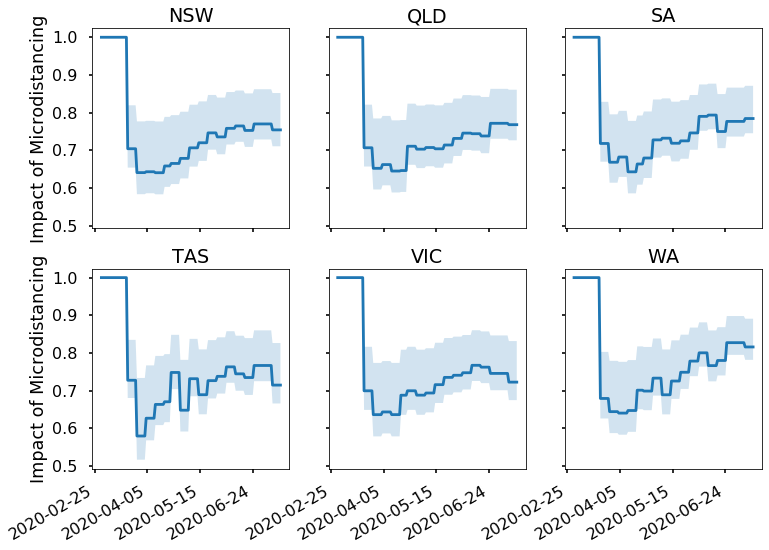

In [20]:
## check md results
from scipy.special import expit
theta_md_mean = np.mean(samples_mov_gamma.theta_md.values)
theta_md_lower = np.quantile(samples_mov_gamma.theta_md.values,0.25)
theta_md_upper = np.quantile(samples_mov_gamma.theta_md.values,0.75)



fig,ax = plt.subplots(figsize=(12,9), nrows=2, ncols=3,sharex=True,sharey=True)
for i,state in enumerate(states_to_fit):
    row = i//3
    col = i%3
    
    counts = survey_counts.loc[:,state]
    respond = survey_respond.loc[:,state].values +0.01
    prop = counts / respond
    
    ax[row, col].plot(counts.index,(1+theta_md_mean)**(-1*prop))
    ax[row,col].fill_between(counts.index, (1+theta_md_lower)**(-1*prop), (1+theta_md_upper)**(-1*prop), alpha=0.2)
    
    ax[row,col].set_title(state)
    
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].tick_params(rotation=30,axis='x')
    
    if col==0:
        ax[row,col].set_ylabel("Impact of Microdistancing")

fig.autofmt_xdate()

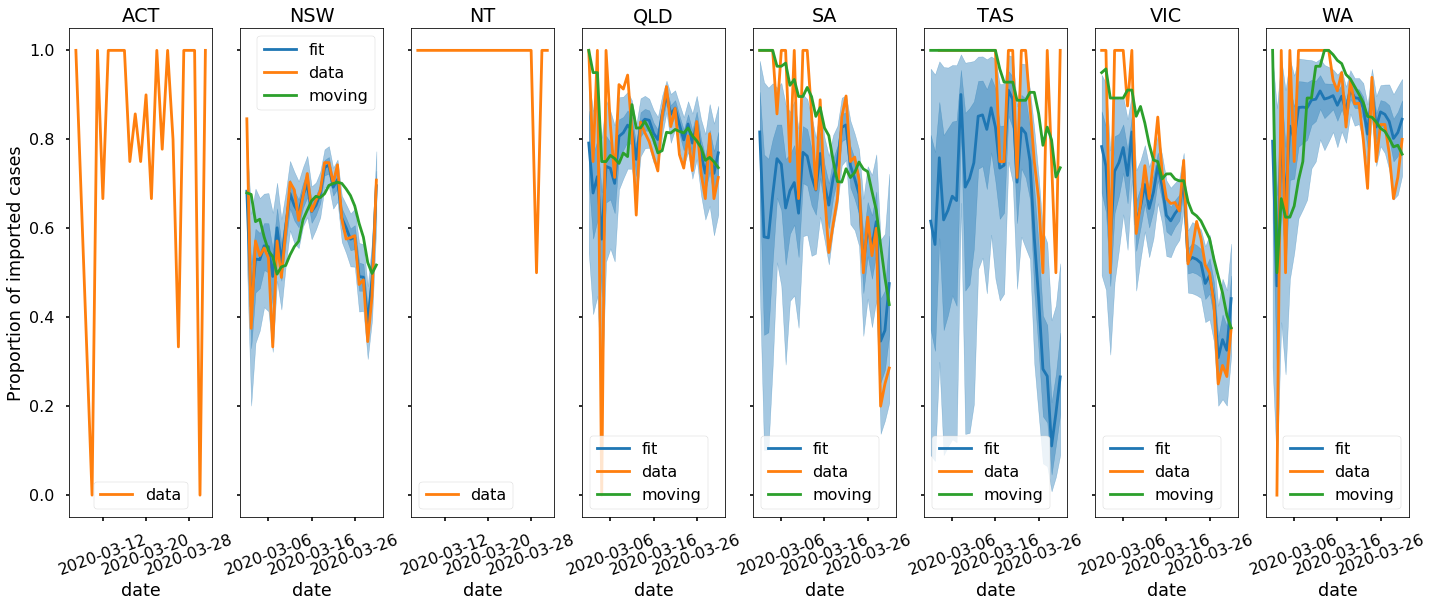

In [21]:
#rho caluclated at data entry
if isinstance(df_state.index, pd.MultiIndex):
    df_state = df_state.reset_index()

    
states=sorted(['NSW','QLD','VIC','TAS','SA','WA','ACT','NT'])
fig,ax = plt.subplots(figsize=(24,9), ncols=len(states),sharey=True)
states_to_fitd = {state: i+1 for i,state in enumerate(states_to_fit)      }

for i, state in enumerate(states):
    if state in states_to_fit:
        dates = df_Reff.loc[(df_Reff.date>=start_date) & 
                            (df_Reff.state==state)&(df_Reff.date<=end_date)].date
        rho_samples = samples_mov_gamma[['brho['+str(j+1)+','+str(states_to_fitd[state])+']' for j in range(dfX.loc[dfX.state=='NSW'].shape[0])]]
        ax[i].plot(dates, rho_samples.median(),label='fit',color='C0')
        ax[i].fill_between(dates, rho_samples.quantile(0.25),rho_samples.quantile(0.75),color='C0',alpha=0.4)
    
        ax[i].fill_between(dates, rho_samples.quantile(0.05),rho_samples.quantile(0.95),color='C0',alpha=0.4)
    else:
        sns.lineplot(x='date_inferred',y='rho',
             data=df_state.loc[(df_state.date_inferred>=start_date) & (df_state.STATE==state)&(df_state.date_inferred<=end_date)], ax=ax[i],color='C1',label='data')
    sns.lineplot(x='date',y='rho',
             data=df_Reff.loc[(df_Reff.date>=start_date) & (df_Reff.state==state)&(df_Reff.date<=end_date)], ax=ax[i],color='C1',label='data')
    sns.lineplot(x='date',y='rho_moving',
             data=df_Reff.loc[(df_Reff.date>=start_date) & (df_Reff.state==state)&(df_Reff.date<=end_date)], ax=ax[i],color='C2',label='moving')
    
    dates = dfX.loc[dfX.state=='NSW'].date
    
    ax[i].tick_params('x',rotation=20)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))    
    ax[i].set_title(state)
ax[0].set_ylabel('Proportion of imported cases')
plt.legend()
plt.show()

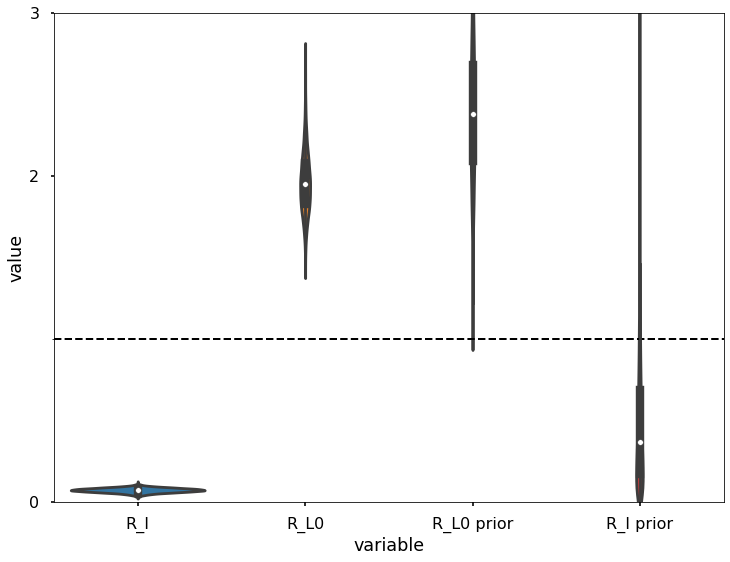

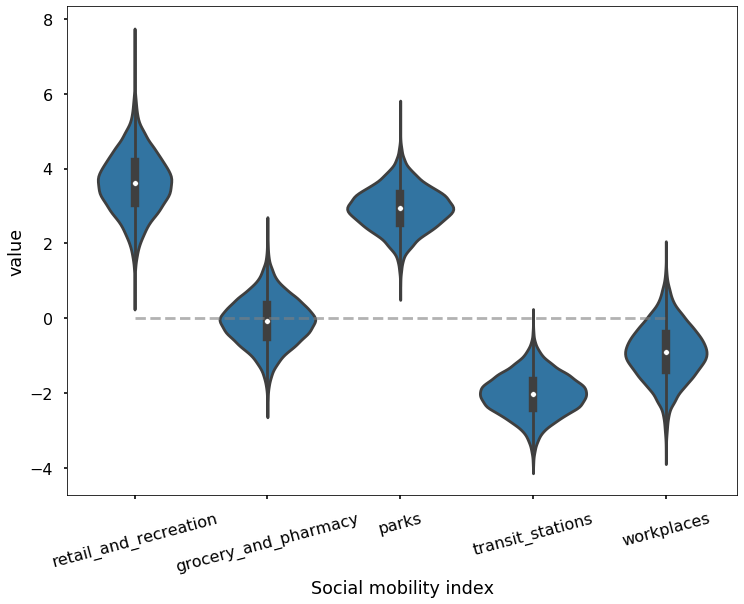

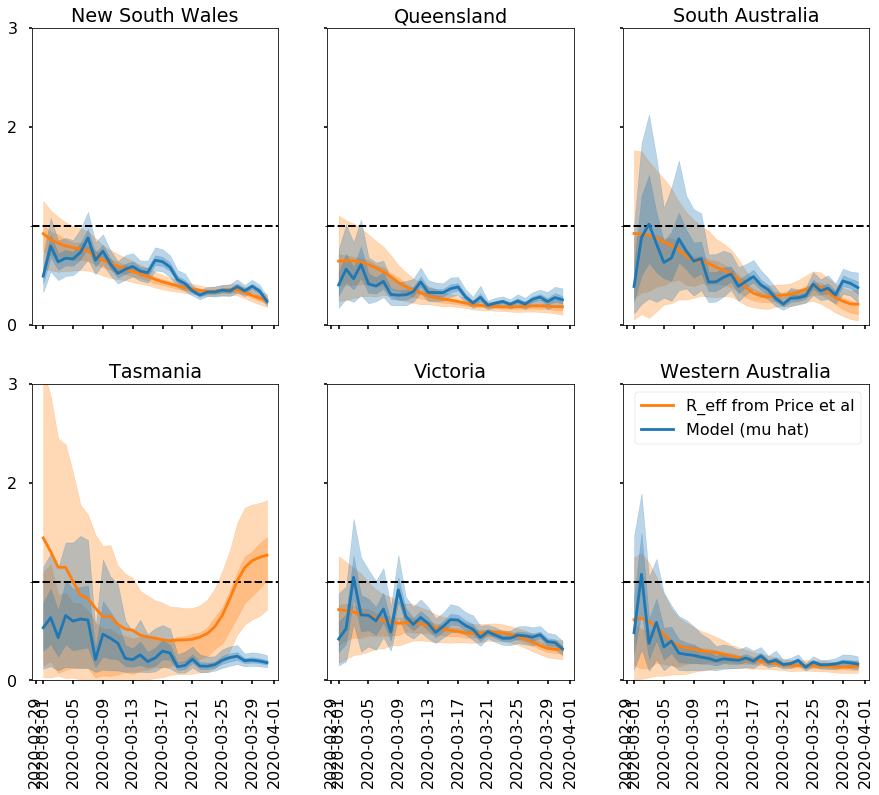

In [22]:
fig,ax = plt.subplots(figsize=(12,9))
samples_mov_gamma['R_L_prior'] = np.random.gamma(
   2.4**2/0.2, 0.2/2.4, size=samples_mov_gamma.shape[0])

samples_mov_gamma['R_I_prior'] = np.random.gamma(
   0.5**2/0.2, .2/0.5, size=samples_mov_gamma.shape[0])

sns.violinplot(x='variable',y='value',
               data=pd.melt(samples_mov_gamma[[col for col in samples_mov_gamma if 'R' in col]]),
              ax=ax,
              cut=0)

ax.set_yticks([1],minor=True,)
ax.set_yticks([0,2,3],minor=False)
ax.set_yticklabels([0,2,3],minor=False)
ax.set_ylim((0,3))
ax.set_xticklabels(['R_I','R_L0','R_L0 prior','R_I prior'])
ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
plt.savefig("R_md_priors.pdf")

posterior = samples_mov_gamma[['bet['+str(i)+']' for i in range(1,1+len(predictors))] 
                             ] 

split=True
md = 'power'#samples_mov_gamma.md.values

posterior.columns = [val for val in predictors] 
long = pd.melt(posterior) 

fig,ax2 =plt.subplots(figsize=(12,9))

ax2 = sns.violinplot(x='variable',y='value',#hue='policy',
                    data=long,
                    ax=ax2,
                     color='C0'
                   )


ax2.plot([0]*len(predictors), linestyle='dashed',alpha=0.6, color = 'grey')
ax2.tick_params(axis='x',rotation=90)

#ax =plot_posterior_violin(posterior)

#ax2.set_title('Coefficients of mobility indices')
ax2.set_xlabel('Social mobility index')
ax2.set_xticklabels([var[:-6] for var in mov_values])
ax2.tick_params('x',rotation=15)
plt.savefig('../figs/mobility_posteriors.pdf')

ax3 =predict_plot(samples_mov_gamma,df.loc[(df.date>=start_date)&(df.date<=end_date)],gamma=True,
                 moving=True,split=split,grocery=True,ban = ban,
                R=samples_mov_gamma.R_L.values, var= True, md_arg=md,
                 rho=states_to_fit, R_I =samples_mov_gamma.R_I.values,prop=survey_X.loc[start_date:end_date])#by states....
for ax in ax3:
    for a in ax:
        a.set_ylim((0,3))
        #a.set_xlim((start_date,end_date))
plt.savefig("../figs/total_Reff_allstates.pdf")
plt.show()

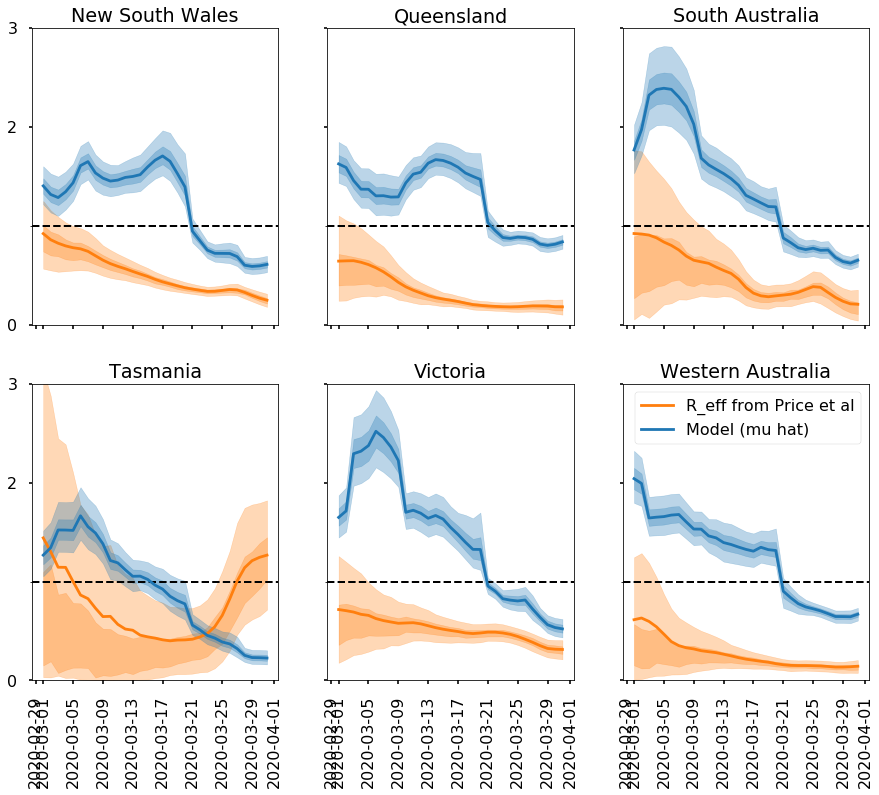

In [23]:
## Just local rates

ax =predict_plot(samples_mov_gamma,df.loc[(df.date>=start_date)&(df.date<=end_date)],gamma=True,
                 moving=True,split=split,grocery=True, ban=ban,
                R=samples_mov_gamma.R_L.values, var= True, md_arg=md,
                 prop=survey_X.loc[start_date:end_date]) #by states....
for ax1 in ax:
    for a in ax1:
        a.set_ylim((0,3))
        #a.set_xlim((start_date,end_date))
plt.savefig("../figs/local_Reff_allstates.pdf")
plt.show()

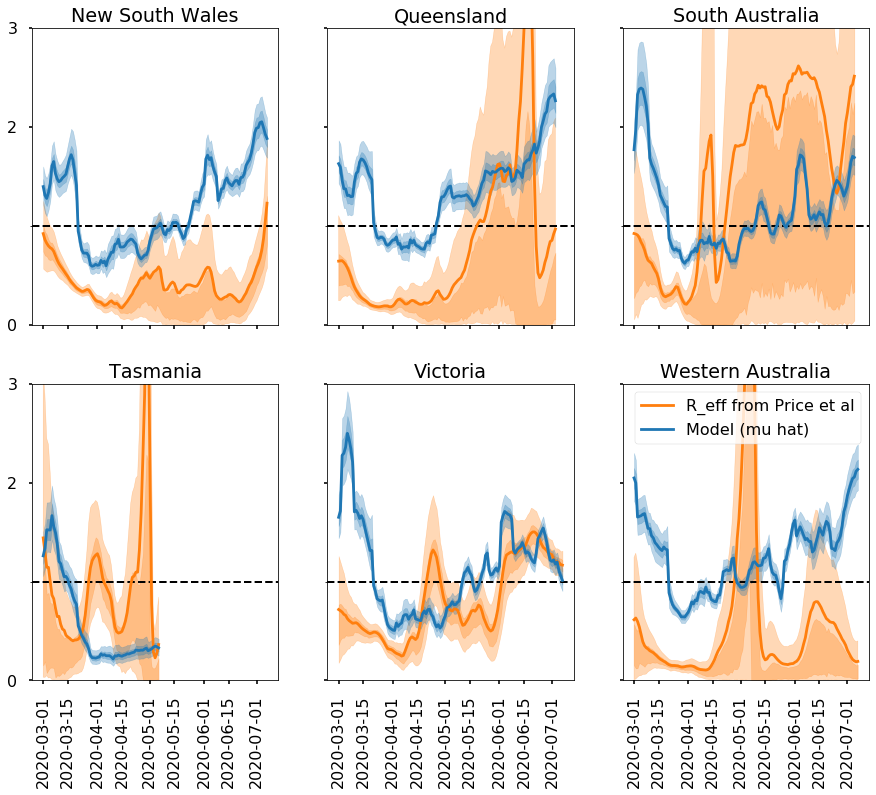

In [24]:
## Just local rates

ax =predict_plot(samples_mov_gamma,df.loc[(df.date>=start_date)],gamma=True,
                 moving=True,split=split,grocery=True, ban=ban,
                R=samples_mov_gamma.R_L.values, var= True, md_arg=md,
                 prop=survey_X.loc[start_date:]) #by states....
for ax1 in ax:
    for a in ax1:
        a.set_ylim((0,3))
        #a.set_xlim((start_date,end_date))
plt.show()

In [104]:
from datetime import datetime
var_to_csv = predictors
samples_mov_gamma[predictors] = samples_mov_gamma[['bet['+str(i)+']' for i in range(1,1+len(predictors))]]
var_to_csv = ['R_I']+['R_L']+['theta_md']+predictors
today = datetime.strftime(datetime.today(),format='%Y-%m-%d')

samples_mov_gamma[var_to_csv].to_hdf('../data/soc_mob_posterior'+today+'.h5',key='samples')

In [84]:
from datetime import datetime
today = datetime.strftime(datetime.today(),format='%Y-%m-%d')
samples_mov_gamma[var_to_csv].to_csv('../data/soc_mob_posterior'+today+'.csv')
samples_mov_gamma[var_to_csv]

,R_I,R_L,theta_md,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days
0,0.072256,1.647023,0.065809,3.595807,-0.096461,2.111120,-1.116858,-0.457805
1,0.076923,1.620540,0.904216,3.571509,0.222612,3.074034,-2.439770,-0.111300
2,0.071491,1.584854,0.444323,3.146109,0.685246,2.354410,-1.768160,-0.297810
3,0.095766,1.562705,0.296870,2.256152,0.909845,3.368412,-1.310151,-0.658169
4,0.116305,1.738037,0.358611,3.124348,-0.054183,3.016206,-1.254679,-0.722778
...,...,...,...,...,...,...,...,...
995,0.099301,1.711098,0.414194,2.546064,-0.198493,2.645450,-0.612377,-1.211825
996,0.102963,2.215233,0.298619,3.141494,-0.454098,3.485706,-0.867359,-0.616016
997,0.078961,1.789050,0.425626,2.833595,0.022461,2.501107,-0.673429,-1.084776
998,0.103783,1.868870,0.654486,2.944096,-0.006508,3.060474,-0.936857,-1.983578


In [85]:

###logistic model
rho_model_gamma = """
data {
    int N; //data length num days
    int K; //Number of mobility indices
    int j; //Number of states
    matrix[N,j] Reff; //response
    matrix[N,K] Mob[j]; //Mobility indices
    matrix[N,K] Mob_std[j]; ///std of mobility
    matrix[N,j] sigma2; //Variances of R_eff from previous study
    vector[N] policy; //Indicators for post policy or not
    matrix[N,j] local; //local number of cases
    matrix[N,j] imported; //imported number of cases

    
    int N_v; //length of VIC days
    int j_v; //second wave states
    matrix[N_v,j_v] Reff_v; //Reff for VIC in June
    matrix[N_v,K] Mob_v[j_v]; //Mob for VIC June
    matrix[N_v,K] Mob_v_std[j_v];// std of mobility
    matrix[N_v,j_v] sigma2_v;// variance of R_eff from previous study
    vector[N_v] policy_v;// micro distancing compliance
    matrix[N_v,j_v] local_v; //local cases in VIC
    matrix[N_v,j_v] imported_v; //imported cases in VIC
    
    vector[N] count_md[j]; //count of always
    vector[N] respond_md[j]; // num respondants
    
    vector[N_v] count_md_v[j_v]; //count of always
    vector[N_v] respond_md_v[j_v]; // num respondants

}
parameters {
    vector[K] bet; //coefficients
    real<lower=0> R_I; //base level imports,
    real<lower=0> R_L; //base level local
    real<lower=0> theta_md; // md weighting
    matrix<lower=0,upper=1>[N,j] prop_md; // proportion who are md'ing
    matrix<lower=0,upper=1>[N_v,j_v] prop_md_v;
    matrix<lower=0,upper=1>[N,j] brho; //estimate of proportion of imported cases
    matrix[N,K] noise[j];
    
    matrix<lower=0,upper=1>[N_v,j_v] brho_v; //estimate of proportion of imported cases
    matrix[N_v,K] noise_v[j_v];
}
transformed parameters {
    matrix[N,j] mu_hat;
    matrix[N_v,j_v] mu_hat_v;
    matrix[N,j] md; //micro distancing
    matrix[N_v,j_v] md_v; 
    
     
    for (i in 1:j) {

        
        for (n in 1:N){

            
            md[n,i] = 2*inv_logit(-1*theta_md *prop_md[n,i]);
            
            mu_hat[n,i] = brho[n,i]*R_I + (1-brho[n,i])*2*R_L*(
            (1-policy[n]) + md[n,i]*policy[n] )*inv_logit(
            noise[j][n,:]*(bet)); //mean estimate
        }
    }
    for (i in 1:j_v){
        for (n in 1:N_v){
            
            md_v[n,i] = 2* inv_logit(-1*theta_md*prop_md_v[n,i]);
            
            mu_hat_v[n,i] = brho_v[n,i]*R_I + (1-brho_v[n,i])*2*R_L*(
                (1-policy_v[n]) + md_v[n,i]*policy_v[n] )*inv_logit(
                noise_v[i][n,:]*(bet)); //mean estimate
        }
    }
    
}
model {
    bet ~ normal(0,1);
    theta_md ~ lognormal(0,1);
    //md ~ beta(7,3);
    
    
    R_L ~ gamma(2.4*2.4/0.2,2.4/0.2);
    R_I ~ gamma(0.5*0.5/.2,0.5/.2);

 
    for (i in 1:j) {
        for (n in 1:N){
            prop_md[n,i] ~ beta(1 + count_md[i][n], 1+ respond_md[i][n] - count_md[i][n]);
            brho[n,i] ~ beta( 1+ imported[n,i], 1+ local[n,i]);
            noise[i][n,:] ~ normal( Mob[i][n,:] , Mob_std[i][n,:]);
            mu_hat[n,i] ~ gamma( Reff[n,i]*Reff[n,i]/(sigma2[n,i]), Reff[n,i]/sigma2[n,i]); //Stan uses shape/inverse scale
        }
    }
    for (i in 1:j_v){
        for (n in 1:N_v){
            prop_md_v[n,i] ~ beta(1 + count_md_v[i][n], 1+ respond_md_v[i][n] - count_md_v[i][n]);
            brho_v[n,i] ~ beta( 1+ imported_v[n,i], 1+ local_v[n,i]);
            noise_v[i][n,:] ~ normal( Mob_v[i][n,:] , Mob_v_std[i][n,:]);
            mu_hat_v[n,i] ~ gamma( Reff_v[n,i]*Reff_v[n,i]/(sigma2_v[n,i]), Reff_v[n,i]/sigma2_v[n,i]);
        }
    }
}
"""

import pystan

sm_pol_log = pystan.StanModel(
    model_code = rho_model_gamma,
    model_name ='gamma_pol_state'
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gamma_pol_state_c7ebb212f88173ea2b9b2b97e4523de6 NOW.


In [86]:
##Make state by state arrays
input_data ={
    'N': dfX.loc[dfX.state=='NSW'].shape[0],
    'K': len(predictors),
    'j':len(states_to_fit),
    'Reff': data_by_state['mean'].values,
    'Mob': mobility_by_state,
    'Mob_std':mobility_std_by_state,
    'sigma2': data_by_state['std'].values**2,
    'policy': policy.values,
    'local':data_by_state['local'].values,
    'imported':data_by_state['imported'].values,
    
    'N_v': df2X.loc[df2X.state=='VIC'].shape[0],
    'j_v': len(sec_states),
    'Reff_v': sec_data_by_state['mean'].values,
    'Mob_v': sec_mobility_by_state,
    'Mob_v_std':sec_mobility_std_by_state,
    'sigma2_v': sec_data_by_state['std'].values**2,
    'policy_v': policy_v,
    'local_v':sec_data_by_state['local'].values,
    'imported_v':sec_data_by_state['imported'].values,
    
    'count_md':count_by_state,
    'respond_md':respond_by_state,
    'count_md_v':sec_count_by_state,
    'respond_md_v':sec_respond_by_state,

}
iterations=2000
chains=2
fit = sm_pol_log.sampling(
    data=input_data,
    iter=iterations,
    chains=chains,
    #control={'max_treedepth':15}
)


print(fit.stansummary(pars=['bet','R_I','R_L','theta_md']))
samples_mov_log = fit.to_dataframe(pars=['bet','R_I','R_L','brho','theta_md'])

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: gamma_pol_state_c7ebb212f88173ea2b9b2b97e4523de6.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bet[1]     2.34    0.03   0.81   0.71   1.83   2.34   2.91   3.88    550    1.0
bet[2]     0.28    0.02   0.56  -0.85   -0.1   0.27   0.65   1.35    554   1.01
bet[3]     3.21    0.02   0.55   2.09   2.84   3.21   3.57   4.29    508    1.0
bet[4]    -1.22    0.02   0.55  -2.33  -1.59   -1.2  -0.85  -0.17    670    1.0
bet[5]    -0.58    0.04   0.75  -2.04  -1.09  -0.59  -0.08   0.94    419    1.0
R_I        0.09  4.6e-4   0.01   0.07   0.08   0.09    0.1   0.12    784    1.0
R_L        1.73  6.4e-3   0.16   1.44   1.61   1.72   1.83   2.07    627   1.01
theta_md   0.65    0.02    0.4    0.1   0.33   0.56   0.89   1.57    465    1.0

Samples were drawn using NUTS at Fri Jul 17 12:03:35 2020.
For each parameter, n_eff 

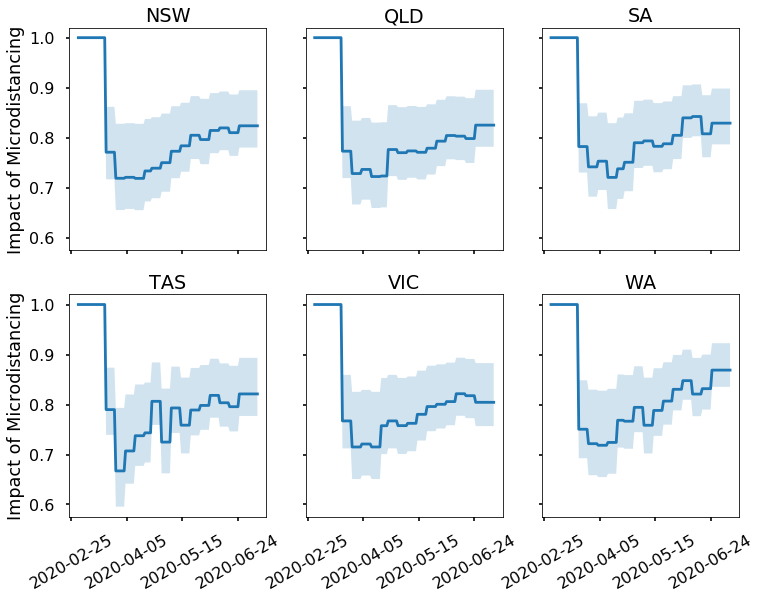

In [87]:
## check md results
from scipy.special import expit
theta_md_mean = np.mean(samples_mov_log.theta_md.values)
theta_md_lower = np.quantile(samples_mov_log.theta_md.values,0.25)
theta_md_upper = np.quantile(samples_mov_log.theta_md.values,0.75)



fig,ax = plt.subplots(figsize=(12,9), nrows=2, ncols=3,sharex=True,sharey=True)
for i,state in enumerate(states_to_fit):
    row = i//3
    col = i%3
    
    counts = survey_counts.loc[:,state]
    respond = survey_respond.loc[:,state].values +0.01
    prop = counts / respond
    
    ax[row, col].plot(counts.index,(1+theta_md_mean)**(-1*prop))
    ax[row,col].fill_between(counts.index, (1+theta_md_lower)**(-1*prop), (1+theta_md_upper)**(-1*prop), alpha=0.2)
    
    ax[row,col].set_title(state)
    
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].tick_params(rotation=30,axis='x')
    
    if col==0:
        ax[row,col].set_ylabel("Impact of Microdistancing")
plt.show()
fig.autofmt_xdate()

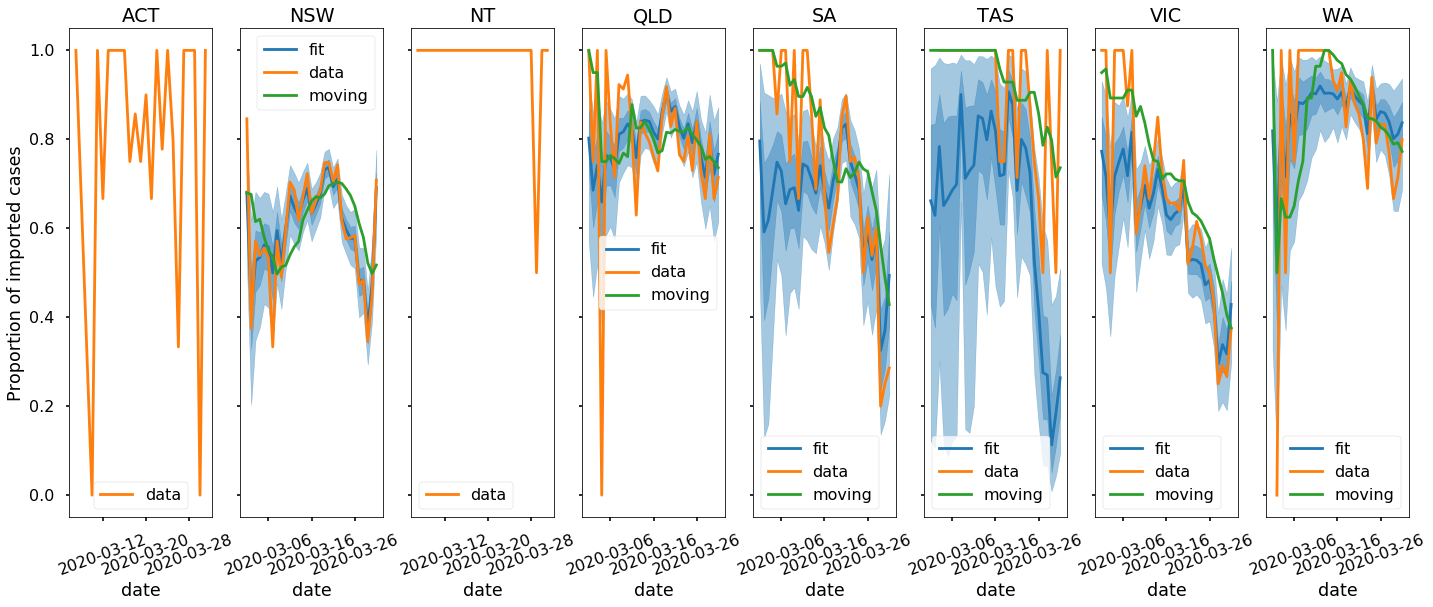

In [88]:
#rho caluclated at data entry
if isinstance(df_state.index, pd.MultiIndex):
    df_state = df_state.reset_index()

    
states=sorted(['NSW','QLD','VIC','TAS','SA','WA','ACT','NT'])
fig,ax = plt.subplots(figsize=(24,9), ncols=len(states),sharey=True)
states_to_fitd = {state: i+1 for i,state in enumerate(states_to_fit)      }

for i, state in enumerate(states):
    if state in states_to_fit:
        dates = df_Reff.loc[(df_Reff.date>=start_date) & 
                            (df_Reff.state==state)&(df_Reff.date<=end_date)].date
        rho_samples = samples_mov_log[['brho['+str(j+1)+','+str(states_to_fitd[state])+']' for j in range(dfX.loc[dfX.state=='NSW'].shape[0])]]
        ax[i].plot(dates, rho_samples.median(),label='fit',color='C0')
        ax[i].fill_between(dates, rho_samples.quantile(0.25),rho_samples.quantile(0.75),color='C0',alpha=0.4)
    
        ax[i].fill_between(dates, rho_samples.quantile(0.05),rho_samples.quantile(0.95),color='C0',alpha=0.4)
    else:
        sns.lineplot(x='date_inferred',y='rho',
             data=df_state.loc[(df_state.date_inferred>=start_date) & (df_state.STATE==state)&(df_state.date_inferred<=end_date)], ax=ax[i],color='C1',label='data')
    sns.lineplot(x='date',y='rho',
             data=df_Reff.loc[(df_Reff.date>=start_date) & (df_Reff.state==state)&(df_Reff.date<=end_date)], ax=ax[i],color='C1',label='data')
    sns.lineplot(x='date',y='rho_moving',
             data=df_Reff.loc[(df_Reff.date>=start_date) & (df_Reff.state==state)&(df_Reff.date<=end_date)], ax=ax[i],color='C2',label='moving')
    
    dates = dfX.loc[dfX.state=='NSW'].date
    
    ax[i].tick_params('x',rotation=20)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))    
    ax[i].set_title(state)
ax[0].set_ylabel('Proportion of imported cases')
plt.legend()
plt.show()

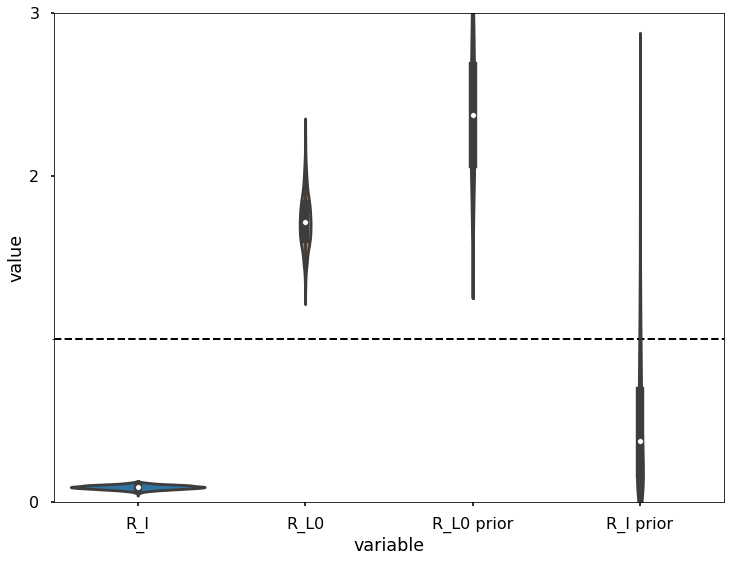

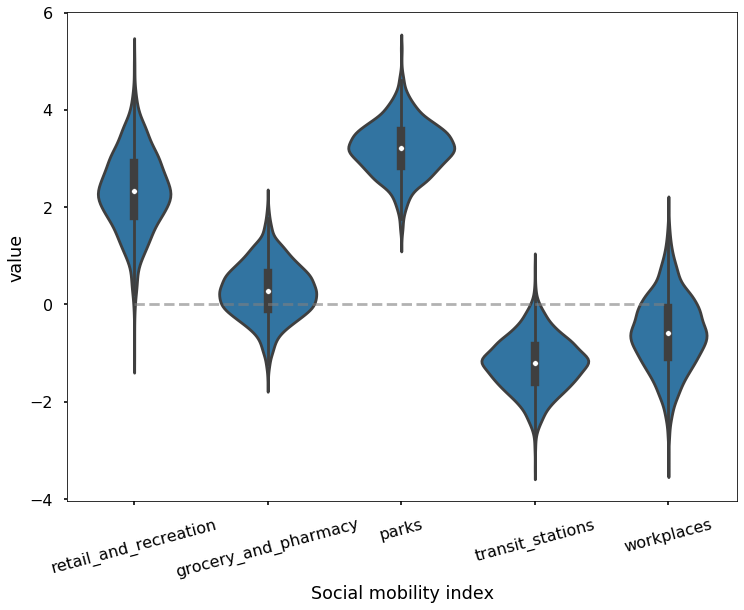

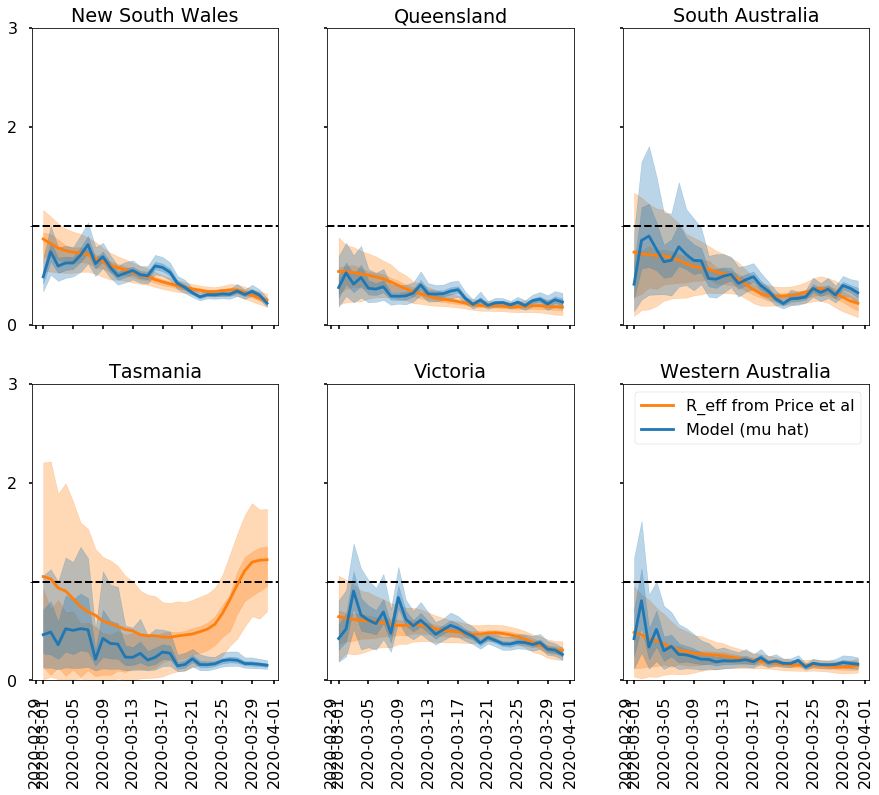

In [89]:
fig,ax = plt.subplots(figsize=(12,9))
samples_mov_log['R_L_prior'] = np.random.gamma(
   2.4**2/0.2, 0.2/2.4, size=samples_mov_log.shape[0])

samples_mov_log['R_I_prior'] = np.random.gamma(
   0.5**2/0.2, .2/0.5, size=samples_mov_log.shape[0])

sns.violinplot(x='variable',y='value',
               data=pd.melt(samples_mov_log[[col for col in samples_mov_log if 'R' in col]]),
              ax=ax,
              cut=0)

ax.set_yticks([1],minor=True,)
ax.set_yticks([0,2,3],minor=False)
ax.set_yticklabels([0,2,3],minor=False)
ax.set_ylim((0,3))
ax.set_xticklabels(['R_I','R_L0','R_L0 prior','R_I prior'])
ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
plt.savefig("R_md_priors.pdf")

posterior = samples_mov_log[['bet['+str(i)+']' for i in range(1,1+len(predictors))] 
                             ] 

split=True
md = 'power'#samples_mov_logg.md.values

posterior.columns = [val for val in predictors] 
long = pd.melt(posterior) 

fig,ax2 =plt.subplots(figsize=(12,9))

ax2 = sns.violinplot(x='variable',y='value',#hue='policy',
                    data=long,
                    ax=ax2,
                     color='C0'
                   )


ax2.plot([0]*len(predictors), linestyle='dashed',alpha=0.6, color = 'grey')
ax2.tick_params(axis='x',rotation=90)

#ax =plot_posterior_violin(posterior)

#ax2.set_title('Coefficients of mobility indices')
ax2.set_xlabel('Social mobility index')
ax2.set_xticklabels([var[:-6] for var in mov_values])
ax2.tick_params('x',rotation=15)
plt.savefig('../figs/mobility_posteriors.pdf')

ax3 =predict_plot(samples_mov_log,df.loc[(df.date>=start_date)&(df.date<=end_date)],gamma=True,
                 moving=True,split=split,grocery=True,ban = ban,
                R=samples_mov_log.R_L.values, var= True, md_arg=md,
                 rho=states_to_fit, R_I =samples_mov_log.R_I.values,prop=survey_X.loc[start_date:end_date])#by states....
for ax in ax3:
    for a in ax:
        a.set_ylim((0,3))
        #a.set_xlim((start_date,end_date))
plt.savefig("../figs/total_Reff_allstates.pdf")
plt.show()

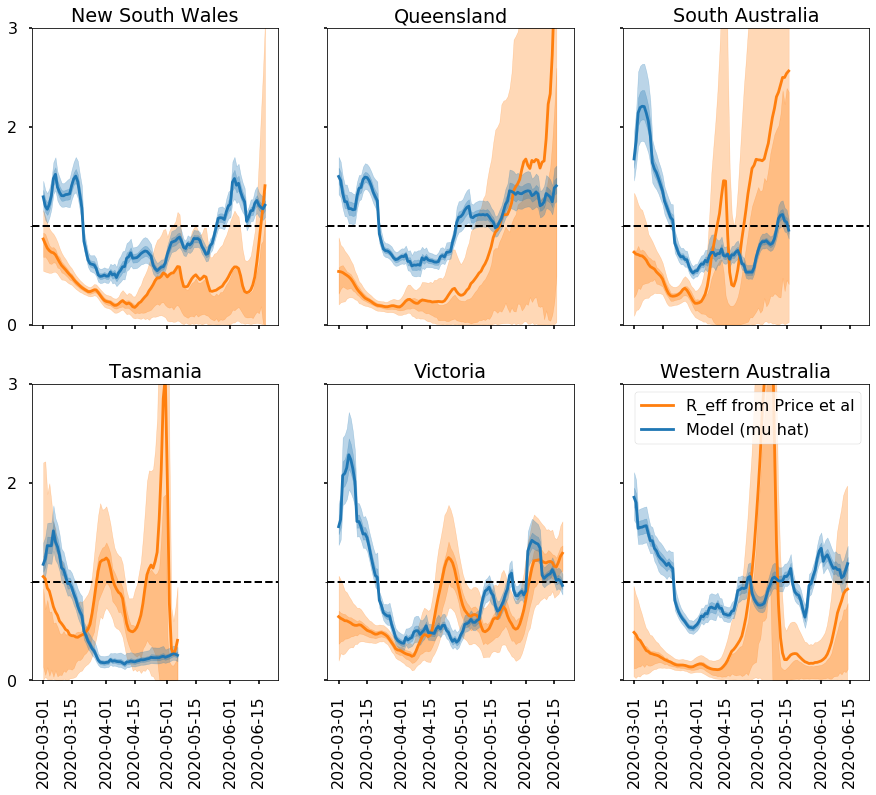

In [90]:
## Just local rates

ax =predict_plot(samples_mov_log,df.loc[(df.date>=start_date)],gamma=True,
                 moving=True,split=split,grocery=True, ban=ban,
                R=samples_mov_log.R_L.values, var= True, md_arg=md,
                 prop=survey_X.loc[start_date:]) #by states....
for ax1 in ax:
    for a in ax1:
        a.set_ylim((0,3))
        #a.set_xlim((start_date,end_date))
plt.show()

In [91]:
from datetime import datetime
var_to_csv = predictors
samples_mov_gamma[predictors] = samples_mov_gamma[['bet['+str(i)+']' for i in range(1,1+len(predictors))]]
var_to_csv = ['R_I']+['R_L']+['theta_md']+predictors
today = datetime.strftime(datetime.today(),format='%Y-%m-%d')

samples_mov_gamma[var_to_csv].to_hdf('../data/soc_mob_posterior_log'+today+'.h5',key='samples')

### Deprecated code

In [7]:
rho_model_winter = """
data {
    int N; //data length num days
    int K; //Number of mobility indices
    int j; //Number of states
    matrix[N,j] Reff; //response
    matrix[N,K] Mob[j]; //Mobility indices
    matrix[N,K] Mob_std[j]; ///std of mobility
    matrix[N,j] sigma2; //Variances of R_eff from previous study
    vector[N] policy; //Indicators for post policy or not
    matrix[N,j] local; //local number of cases
    matrix[N,j] imported; //imported number of cases
    //matrix[N,j] rho; //proportion of imported cases
    
    int N_v; //length of VIC days
    int j_v; //second wave states
    matrix[N_v,j_v] Reff_v; //Reff for VIC in June
    matrix[N_v,K] Mob_v[j_v]; //Mob for VIC June
    matrix[N_v,K] Mob_v_std[j_v];// std of mobility
    matrix[N_v,j_v] sigma2_v;// variance of R_eff from previous study
    vector[N_v] policy_v;// micro distancing compliance
    matrix[N_v,j_v] local_v; //local cases in VIC
    matrix[N_v,j_v] imported_v; //imported cases in VIC
    

}
parameters {
    vector[K] bet; //coefficients
    real<lower=0> R_I; //base level imports,
    real<lower=0> R_L; //base level local
    real<lower=0,upper=1> md; //micro distancing
    real<lower=0,upper=1> winter; // winter changes
    matrix<lower=0,upper=1>[N,j] brho; //estimate of proportion of imported cases
    matrix[N,K] noise[j];
    
    matrix<lower=0,upper=1>[N_v,j_v] brho_v; //estimate of proportion of imported cases
    matrix[N_v,K] noise_v[j_v];
}
transformed parameters {
    matrix[N,j] mu_hat;
    matrix[N_v,j_v] mu_hat_v;

    for (i in 1:j) {
        
        for (n in 1:N){
            mu_hat[n,i] = brho[n,i]*R_I + (1-brho[n,i])*2*R_L*(
            (1-policy[n]) + md*policy[n] )*inv_logit(
            noise[j][n,:]*(bet)); //mean estimate
        }
    }
    for (i in 1:j_v){
        for (n in 1:N_v){
            mu_hat_v[n,i] = brho_v[n,i]*R_I + (1-brho_v[n,i])*2*(1+winter)*R_L*(
                (1-policy_v[n]) + 0.5*md*policy_v[n] )*inv_logit(
                noise_v[i][n,:]*(bet)); //mean estimate
        }
    }
    
}
model {
    bet ~ normal(0,1);
    md ~ beta(7,3);
    winter ~ beta(3,7);
    
    R_L ~ gamma(2.4*2.4/0.2,2.4/0.2);
    R_I ~ gamma(0.5*0.5/.2,0.5/.2);

 
    for (i in 1:j) {
        for (n in 1:N){
            brho[n,i] ~ beta( 1+ imported[n,i], 1+ local[n,i]);
            noise[i][n,:] ~ normal( Mob[i][n,:] , Mob_std[i][n,:]);
            mu_hat[n,i] ~ gamma( Reff[n,i]*Reff[n,i]/(sigma2[n,i]), Reff[n,i]/sigma2[n,i]); //Stan uses shape/inverse scale
        }
    }
    for (i in 1:j_v){
        for (n in 1:N_v){
             brho_v[n,i] ~ beta( 1+ imported_v[n,i], 1+ local_v[n,i]);
                noise_v[i][n,:] ~ normal( Mob_v[i][n,:] , Mob_v_std[i][n,:]);
                mu_hat_v[n,i] ~ gamma( Reff_v[n,i]*Reff_v[n,i]/(sigma2_v[n,i]), Reff_v[n,i]/sigma2_v[n,i]);
        }
    }
}
"""

import pystan

sm_pol_winter = pystan.StanModel(
    model_code = rho_model_winter,
    model_name ='gamma_pol_winter',
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gamma_pol_winter_bcd73f7269a14053436b9956b2bb6d58 NOW.


In [23]:
##### Create useable dataset
## ACT and NT not in original estimates, need to extrapolated
states_to_fit = sorted(['NSW','VIC','QLD','SA','WA','TAS']) #sorting keeps consistent with sort in data_by_state
fit_post_March = True
ban = '2020-03-16'
start_date = '2020-03-01'
end_date = '2020-03-31'

##Second wave inputs
sec_states=['VIC']
sec_start_date = '2020-06-01'
sec_end_date = '2020-06-18' #all we have for now

fit_mask = df.state.isin(states_to_fit)
if fit_post_March:
    fit_mask = (fit_mask) & (df.date >= start_date)
    
fit_mask = (fit_mask) & (df.date <= end_date )

second_wave_mask = df.state.isin(sec_states)
second_wave_mask = (second_wave_mask) & (df.date >= sec_start_date)
second_wave_mask = (second_wave_mask) & (df.date <= sec_end_date)


predictors = mov_values.copy()
#predictors.extend(['driving_7days','transit_7days','walking_7days','pc'])

#remove residential to see if it improves fit
predictors.remove('residential_7days')

df['post_policy'] = (df.date >= ban).astype(int)

dfX = df.loc[fit_mask].sort_values('date')
df2X = df.loc[second_wave_mask].sort_values('date')

data_by_state= {}
sec_data_by_state={}
for value in ['mean','std','local','imported']:
    data_by_state[value] = pd.pivot(dfX[['state',value,'date']], 
                           index='date',columns='state',values=value).sort_index(
        axis='columns')
    sec_data_by_state[value] = pd.pivot(df2X[['state',value,'date']], 
                           index='date',columns='state',values=value).sort_index(
        axis='columns')
mobility_by_state =[]
mobility_std_by_state=[]
for state in states_to_fit:
    print(state)
    mobility_by_state.append(dfX.loc[dfX.state==state, predictors].values/100)
    mobility_std_by_state.append(
        dfX.loc[dfX.state==state,[val+'_std' for val in predictors]].values/100
    )
sec_mobility_by_state =[]
sec_mobility_std_by_state=[]
print('Second wave states')
for state in sec_states:
    print(state)
    sec_mobility_by_state.append(df2X.loc[df2X.state==state, predictors].values/100)
    sec_mobility_std_by_state.append(
        df2X.loc[df2X.state==state,[val+'_std' for val in predictors]].values/100
    )
policy_v = [1]*df2X.loc[df2X.state=='VIC'].shape[0]
policy = dfX.loc[dfX.state=='NSW','post_policy']

NSW
QLD
SA
TAS
VIC
WA
Second wave states
VIC


In [24]:
##Make state by state arrays
input_data ={
    'N': dfX.loc[dfX.state=='NSW'].shape[0],
    'K': len(predictors),
    'j':len(states_to_fit),
    'Reff': data_by_state['mean'].values,
    'Mob': mobility_by_state,
    'Mob_std':mobility_std_by_state,
    'sigma2': data_by_state['std'].values**2,
    'policy': policy.values,
    'local':data_by_state['local'].values,
    'imported':data_by_state['imported'].values,
    
    'N_v': df2X.loc[df2X.state=='VIC'].shape[0],
    'j_v': len(sec_states),
    'Reff_v': sec_data_by_state['mean'].values,
    'Mob_v': sec_mobility_by_state,
    'Mob_v_std':sec_mobility_std_by_state,
    'sigma2_v': sec_data_by_state['std'].values**2,
    'policy_v': policy_v,
    'local_v':sec_data_by_state['local'].values,
    'imported_v':sec_data_by_state['imported'].values

}
iterations=1000
chains=2
fit = sm_pol_winter.sampling(
    data=input_data,
    iter=iterations,
    chains=chains,
    #control={'max_treedepth':15}
)


print(fit.stansummary(pars=['bet','R_I','R_L','md','winter']))
samples_mov_winter = fit.to_dataframe(pars=['bet','R_I','R_L','md','brho','winter'])

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: gamma_pol_winter_bcd73f7269a14053436b9956b2bb6d58.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bet[1]   2.28    0.03    0.8   0.79   1.74   2.26   2.84   3.86    612    1.0
bet[2]   0.54    0.02   0.52  -0.46   0.19   0.54   0.88   1.59    473   1.01
bet[3]   3.84    0.02   0.53   2.85   3.48   3.83   4.21   4.94    779    1.0
bet[4]  -1.35    0.02   0.58   -2.5  -1.73  -1.34  -0.95  -0.21    598    1.0
bet[5]  -0.65    0.04   0.79  -2.17  -1.19  -0.64  -0.14   0.93    463    1.0
R_I      0.09  5.6e-4   0.01   0.06   0.08   0.09    0.1   0.12    561    1.0
R_L      1.82  6.6e-3   0.17   1.52    1.7   1.81   1.93   2.15    617    1.0
md       0.89  1.5e-3   0.05   0.77   0.85   0.89   0.93   0.98   1260    1.0
winter   0.79  2.1e-3   0.07   0.62   0.74    0.8   0.84   0.91   1198    1.0

Samples were drawn using N

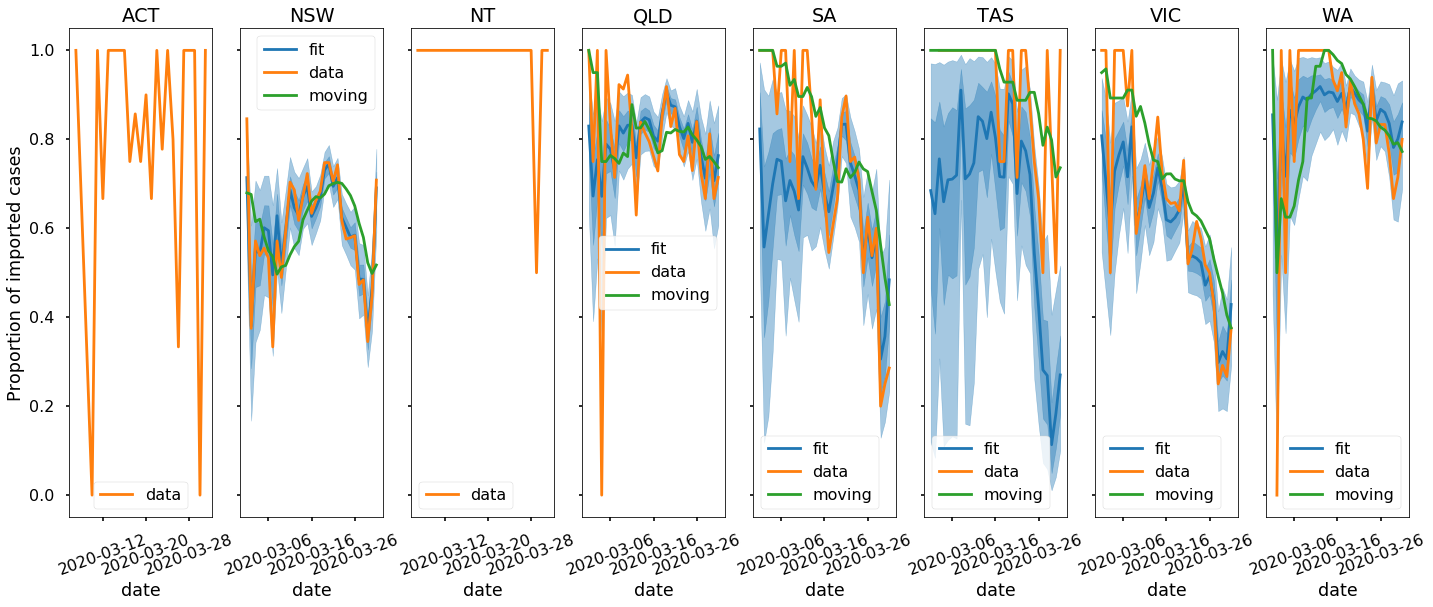

In [25]:
#rho caluclated at data entry
if isinstance(df_state.index, pd.MultiIndex):
    df_state = df_state.reset_index()

    
states=sorted(['NSW','QLD','VIC','TAS','SA','WA','ACT','NT'])
fig,ax = plt.subplots(figsize=(24,9), ncols=len(states),sharey=True)
states_to_fitd = {state: i+1 for i,state in enumerate(states_to_fit)      }

for i, state in enumerate(states):
    if state in states_to_fit:
        dates = df_Reff.loc[(df_Reff.date>=start_date) & 
                            (df_Reff.state==state)&(df_Reff.date<=end_date)].date
        rho_samples = samples_mov_gamma[['brho['+str(j+1)+','+str(states_to_fitd[state])+']' for j in range(dfX.loc[dfX.state=='NSW'].shape[0])]]
        ax[i].plot(dates, rho_samples.median(),label='fit',color='C0')
        ax[i].fill_between(dates, rho_samples.quantile(0.25),rho_samples.quantile(0.75),color='C0',alpha=0.4)
    
        ax[i].fill_between(dates, rho_samples.quantile(0.05),rho_samples.quantile(0.95),color='C0',alpha=0.4)
    else:
        sns.lineplot(x='date_inferred',y='rho',
             data=df_state.loc[(df_state.date_inferred>=start_date) & (df_state.STATE==state)&(df_state.date_inferred<=end_date)], ax=ax[i],color='C1',label='data')
    sns.lineplot(x='date',y='rho',
             data=df_Reff.loc[(df_Reff.date>=start_date) & (df_Reff.state==state)&(df_Reff.date<=end_date)], ax=ax[i],color='C1',label='data')
    sns.lineplot(x='date',y='rho_moving',
             data=df_Reff.loc[(df_Reff.date>=start_date) & (df_Reff.state==state)&(df_Reff.date<=end_date)], ax=ax[i],color='C2',label='moving')
    
    dates = dfX.loc[dfX.state=='NSW'].date
    
    ax[i].tick_params('x',rotation=20)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))    
    ax[i].set_title(state)
ax[0].set_ylabel('Proportion of imported cases')
plt.legend()
plt.show()

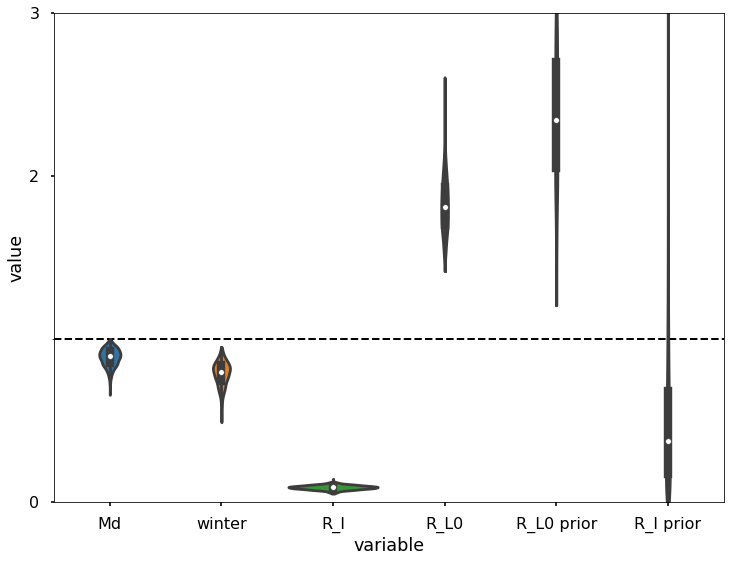

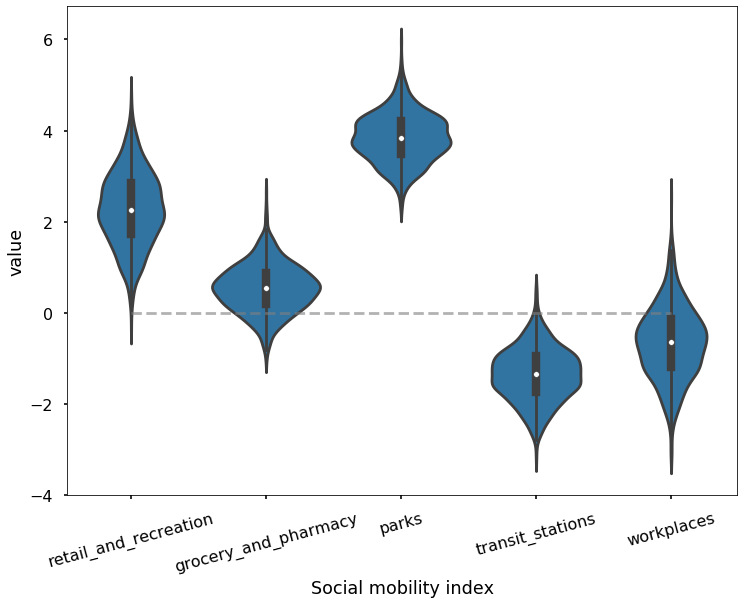

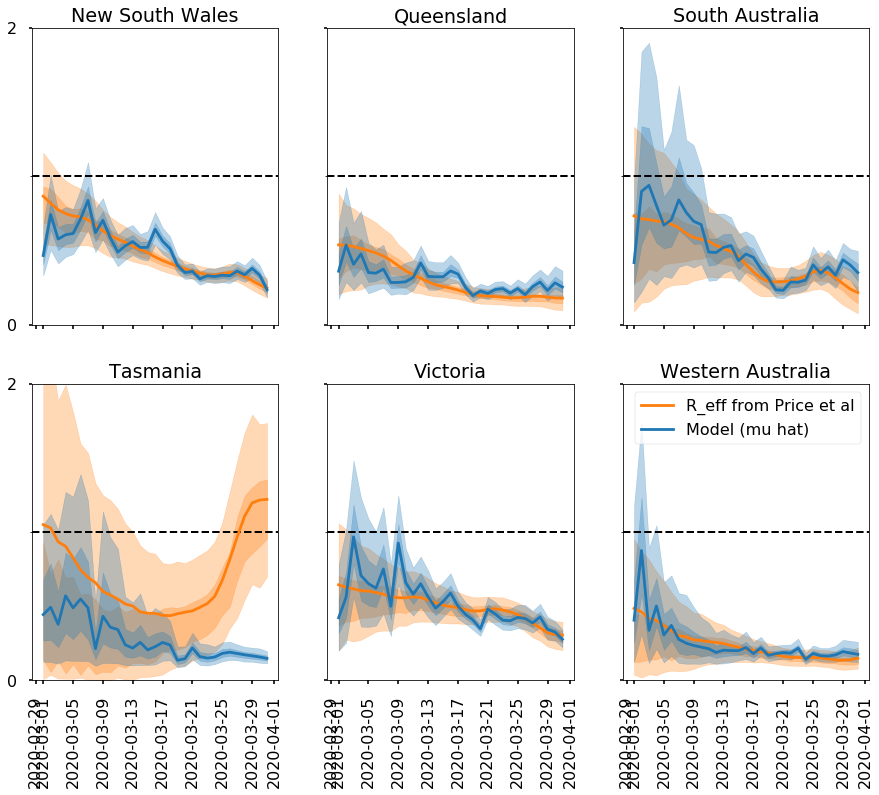

In [29]:
fig,ax = plt.subplots(figsize=(12,9))
samples_mov_winter['R_L_prior'] = np.random.gamma(
   2.4**2/0.2, 0.2/2.4, size=samples_mov_winter.shape[0])

samples_mov_winter['R_I_prior'] = np.random.gamma(
   0.5**2/0.2, .2/0.5, size=samples_mov_winter.shape[0])

sns.violinplot(x='variable',y='value',
               data=pd.melt(samples_mov_winter[['md','winter']+[col for col in samples_mov_winter if 'R' in col]]),
              ax=ax,
              cut=0)

ax.set_yticks([1],minor=True,)
ax.set_yticks([0,2,3],minor=False)
ax.set_yticklabels([0,2,3],minor=False)
ax.set_ylim((0,3))
ax.set_xticklabels(['Md','winter','R_I','R_L0','R_L0 prior','R_I prior'])
ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
#plt.savefig("R_md_priors.pdf")

posterior = samples_mov_winter[['bet['+str(i)+']' for i in range(1,1+len(predictors))] 
                             ] 

split=True
md = samples_mov_winter.md.values

posterior.columns = [val for val in predictors] 
long = pd.melt(posterior) 

fig,ax2 =plt.subplots(figsize=(12,9))

ax2 = sns.violinplot(x='variable',y='value',#hue='policy',
                    data=long,
                    ax=ax2,
                     color='C0'
                   )


ax2.plot([0]*len(predictors), linestyle='dashed',alpha=0.6, color = 'grey')
ax2.tick_params(axis='x',rotation=90)


ax2.set_xlabel('Social mobility index')
ax2.set_xticklabels([var[:-6] for var in mov_values])
ax2.tick_params('x',rotation=15)
#plt.savefig('../figs/mobility_posteriors.pdf')

ax3 =predict_plot(samples_mov_winter,df.loc[(df.date>=start_date)&(df.date<=end_date)],gamma=True,
                 moving=True,split=split,grocery=True,ban = ban,
                R=samples_mov_winter.R_L.values, var= True, md=md,
                 rho=states_to_fit, R_I =samples_mov_winter.R_I.values)#by states....
for ax in ax3:
    for a in ax:
        a.set_ylim((0,2))
       
#plt.savefig("../figs/total_Reff_allstates.pdf")
plt.show()

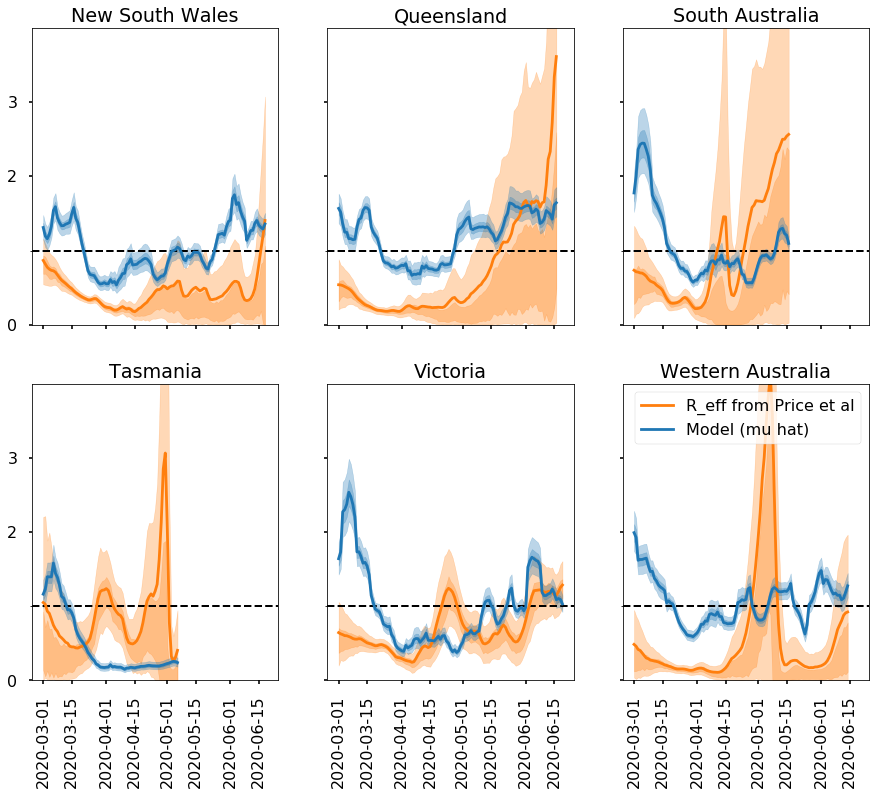

In [30]:
## Just local rates

ax =predict_plot(samples_mov_winter,df.loc[df.date>='2020-03-01'],gamma=True,
                 moving=True,split=split,grocery=True,
                R=samples_mov_winter.R_L.values, var= True, md=md,
                 ) #by states....

#plt.savefig("local_Reff_allstates.pdf")
plt.show()

In [28]:
from corner import corner

corner(samples_mov_gamma[['R_I','R_L','md','beta[1]','beta[2]','beta[3]','beta[4]','beta[5]']])

plt.show()

KeyError: "['beta[3]', 'beta[2]', 'beta[1]', 'beta[4]', 'beta[5]'] not in index"

In [ ]:
def set_baseline_val(df, col:str, end_date, start_date=None, interval=None):
    """
    Given a column name and date start, append a new column to the df with new baseline based on same day of week
    """
    from datetime import datetime as dt
    from datetime import timedelta
   
    if start_date is None:
        start_date = end_date + timedelta(days=interval)
    
    mask = generate_mask(df['date'], start_date=start_date, end_date=end_date)
        
    df_filtered = df.loc[mask]
    days =  df_filtered.day.unique() # Days to consider as baseline
    
    for day in days:
        id_map ={}
        for sa2 in df_filtered.id:
        # Iterate over each id 
            try:
                id_map[sa2] = df_filtered.loc[(df_filtered.day==day)
                                              & (df_filtered.id==sa2), col].values[0]
            except IndexError:
                print(str(sa2) + 'id region on day '+str(day) +' does not have data')
                continue
                    
        df.loc[df.day==day,'base_'+col+dt.strftime(start_date,format='%Y-%m-%d')] = df.loc[df.day==day].id.map(id_map)
    
    return df

def percentage_change(df, base:str, newcol:str, val:str):
    """
    Calculate percentage change of column val from baseline col into a newcol that is a percentage change
    """
    
    df[newcol] = (df[val] - df[base])/df[base] * 100
    return df

def generate_mask(s_date,start_date=None, end_date=None, interval=None ):
    """
    Generate mask to based on if s_date lies within (inclusive of) a date range.
    Note: to use timedelta, need dates to include timezone
    """
    from datetime import timedelta
    if start_date is None:  
        start_date = end_date + timedelta(days=interval)
    elif end_date is None:
        end_date = start_date + timedelta(days=interval)
             
    mask = (s_date >= start_date) & (s_date <= end_date)

    return mask

In [ ]:
start = dt.strptime('2020-01-20+0000', '%Y-%m-%d%z')
end = dt.strptime('2020-04-27+0000','%Y-%m-%d%z')
mask = generate_mask(df_ai.date, start_date=start, end_date=end)

start = dt.strptime('2019-01-20+0000', '%Y-%m-%d%z')
end = dt.strptime('2019-04-27+0000','%Y-%m-%d%z')
mask2 = generate_mask(df_ai.date, start_date=start, end_date=end)

PH2019 = (dt.strptime('2019-04-19+0000', '%Y-%m-%d%z'), 
              dt.strptime('2019-04-20+0000', '%Y-%m-%d%z'),
             dt.strptime('2019-04-21+0000', '%Y-%m-%d%z'),
             dt.strptime('2019-04-22+0000', '%Y-%m-%d%z'),
             dt.strptime('2019-04-25+0000', '%Y-%m-%d%z')
         )